In [1]:
import covid_feature_extraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression

C:\Users\Matt\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [2]:
def lasso_coefs(X, y, feature_labels, plot=False, save=False, save_county=None):
    kf = KFold(n_splits=5)
    lambdas = np.logspace(-8,-1,100)

    scores = []
    min_error = 1e6
    min_index = 0
    coefs = []

    X = np.array(X)
    y = np.array(y)

    for i in range(len(lambdas)):
        score_arr = []
        coef_arr = []
        for train_indices, test_indices in kf.split(X):
            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            lasso = Lasso(alpha=lambdas[i],max_iter=10000).fit(X_train, y_train)
            coef_arr.append(lasso.coef_)
            y_pred = lasso.predict(X_test)
            score_arr.append(mean_squared_error(y_test, y_pred))
        avg_score = np.array(score_arr).mean()
        if avg_score <= min_error:
            min_error = avg_score
            min_index = i
            best_lambda = lambdas[i]
        scores.append(avg_score)
        coefs.append(np.array(coef_arr).mean(axis=0))

    if plot:
        fig, ax1 = plt.subplots(figsize=(15,6))
        coefs = np.array(coefs)
        for i in range(len(coefs.T)):
            ax1.plot(lambdas,coefs[:,i],label=feature_labels[i])
        ax1.set_xscale("log")
        ax1.set_ylabel("Coefficients",fontsize=14,labelpad=8)
        ax1.set_xlabel(r"$\lambda$",fontsize=14,labelpad=8)
        ax1.tick_params(axis='both', which='major', labelsize=12)
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()

        ax2.plot(lambdas,scores,color='k',linestyle='--',alpha=0.5,label="Error")
        ax2.axvline(best_lambda,color='red',linestyle='--',alpha=0.5)
        ax2.set_ylabel("Mean Squared Error",fontsize=14,labelpad=8)
        ax2.tick_params(axis='both', which='major', labelsize=12)

        if save:
            plt.savefig("{}_lasso_coefs.png".format(save_county))
        plt.show()
    
    return coefs[min_index]

# Population Not Staying Home

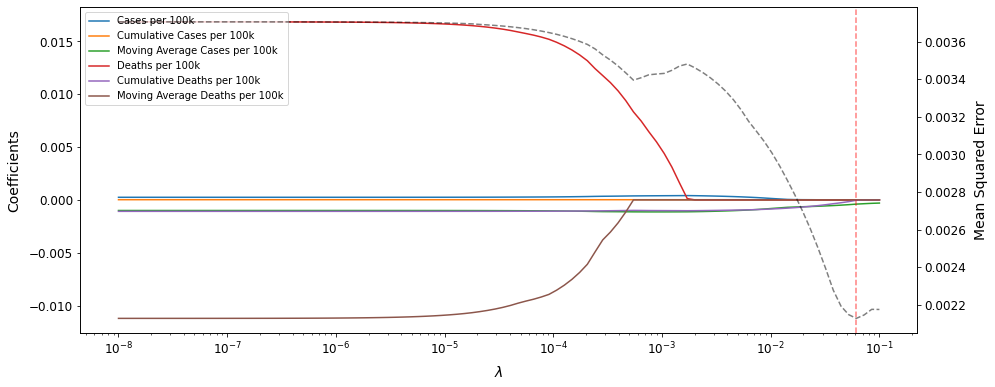

Cases per 100k
----------------------
F: 7.891686990513972
p: 0.005206853249307017

Cumulative Cases per 100k
----------------------
F: 68.3763870544278
p: 1.960179313258788e-15

Moving Average Cases per 100k
----------------------
F: 10.421034769483116
p: 0.0013473152383970642

Deaths per 100k
----------------------
F: 28.48916929391348
p: 1.5725540007255683e-07

Cumulative Deaths per 100k
----------------------
F: 61.32223670447778
p: 4.28940385287908e-14

Moving Average Deaths per 100k
----------------------
F: 24.75222058052931
p: 9.654554888587046e-07



In [20]:
state_trip_dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Population")
state_Fvals, state_pvals = f_regression(state_X, state_y)
state_coefs = lasso_coefs(state_X, state_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}".format(state_Fvals[i],state_pvals[i]))
    print()

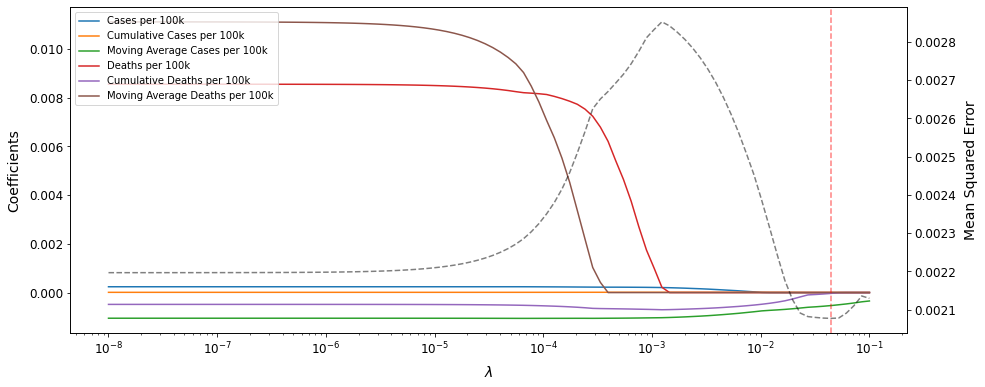

Cases per 100k
----------------------
F: 11.444672341506616
p: 0.0007868241392736062
Lasso: 0.0

Cumulative Cases per 100k
----------------------
F: 48.41217452531342
p: 1.3962937250807489e-11
Lasso: 4.569309315606233e-06

Moving Average Cases per 100k
----------------------
F: 14.151047909465502
p: 0.0001935876202014961
Lasso: -0.0005337617225214679

Deaths per 100k
----------------------
F: 18.33282172320854
p: 2.3184892455280938e-05
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 42.70758223385622
p: 1.9136598614139503e-10
Lasso: -3.443730450175182e-05

Moving Average Deaths per 100k
----------------------
F: 37.230298993357124
p: 2.455956150245064e-09
Lasso: 0.0



In [4]:
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Population")
fulton_Fvals, fulton_pvals = f_regression(fulton_X, fulton_y)
fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(fulton_Fvals[i],fulton_pvals[i],fulton_coefs[i]))
    print()

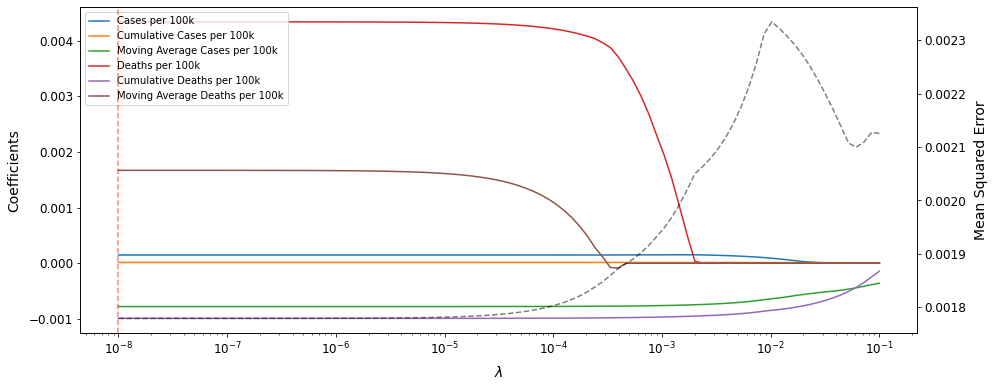

Cases per 100k
----------------------
F: 7.373193362894972
p: 0.006903604804815225
Lasso: 0.00014846927470910676

Cumulative Cases per 100k
----------------------
F: 63.352288028064166
p: 1.7557282761466275e-14
Lasso: 1.4324252635035081e-05

Moving Average Cases per 100k
----------------------
F: 22.32561959981727
p: 3.1791250348164904e-06
Lasso: -0.0007776694983750783

Deaths per 100k
----------------------
F: 2.460814768708583
p: 0.11749916001343504
Lasso: 0.004336304437375355

Cumulative Deaths per 100k
----------------------
F: 26.828110700608697
p: 3.5127614666920447e-07
Lasso: -0.0009900630142748753

Moving Average Deaths per 100k
----------------------
F: 0.11067563291467905
p: 0.7395483755110588
Lasso: 0.0016693682680133637



In [5]:
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Population")
lowndes_Fvals, lowndes_pvals = f_regression(lowndes_X, lowndes_y)
lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(lowndes_Fvals[i],lowndes_pvals[i],lowndes_coefs[i]))
    print()

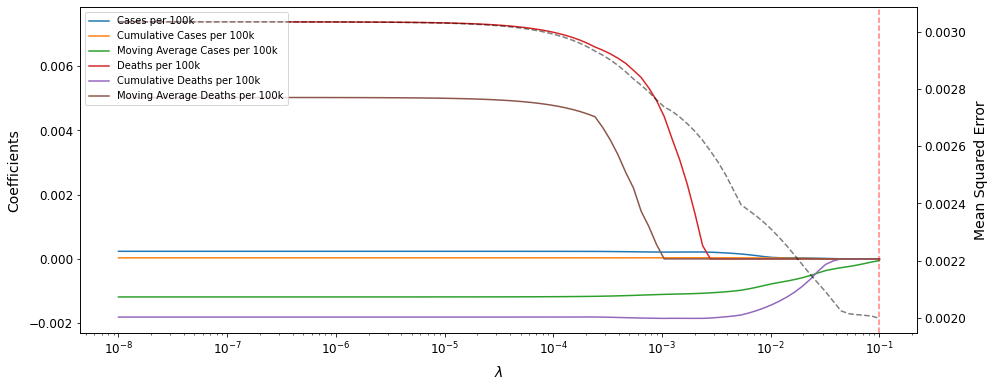

Cases per 100k
----------------------
F: 5.63393519286352
p: 0.01808173540764019
Lasso: 0.0

Cumulative Cases per 100k
----------------------
F: 4.630779959988582
p: 0.03199378043723227
Lasso: 3.2298249997660893e-07

Moving Average Cases per 100k
----------------------
F: 10.030711454301878
p: 0.0016561064140695918
Lasso: -5.30739779085706e-05

Deaths per 100k
----------------------
F: 8.344449342960505
p: 0.004076376811022164
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 3.745809762793769
p: 0.05363584248539416
Lasso: 0.0

Moving Average Deaths per 100k
----------------------
F: 2.5720096131622543
p: 0.10954899906607407
Lasso: 0.0



In [6]:
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Population")
chatham_Fvals, chatham_pvals = f_regression(chatham_X, chatham_y)
chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(chatham_Fvals[i],chatham_pvals[i],chatham_coefs[i]))
    print()

# Long Trips

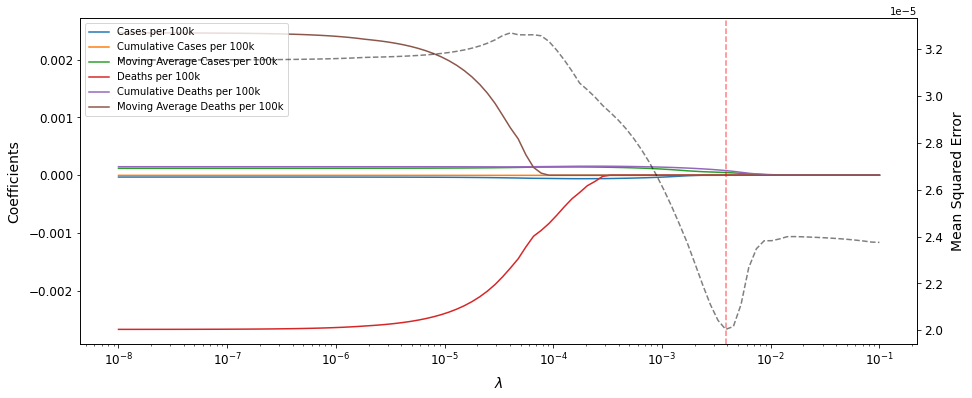

Cases per 100k
----------------------
F: 0.27618426281201325
p: 0.5995007669517725

Cumulative Cases per 100k
----------------------
F: 54.753899323616615
p: 7.95572252968514e-13

Moving Average Cases per 100k
----------------------
F: 0.0017243232864887117
p: 0.9668978485685286

Deaths per 100k
----------------------
F: 28.159697430897623
p: 1.8436616503365245e-07

Cumulative Deaths per 100k
----------------------
F: 40.440105361979036
p: 5.478207147511673e-10

Moving Average Deaths per 100k
----------------------
F: 13.471283650200586
p: 0.00027465535451230927



In [21]:
state_trip_dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Long")
state_Fvals, state_pvals = f_regression(state_X, state_y)
state_coefs = lasso_coefs(state_X, state_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}".format(state_Fvals[i],state_pvals[i]))
    print()

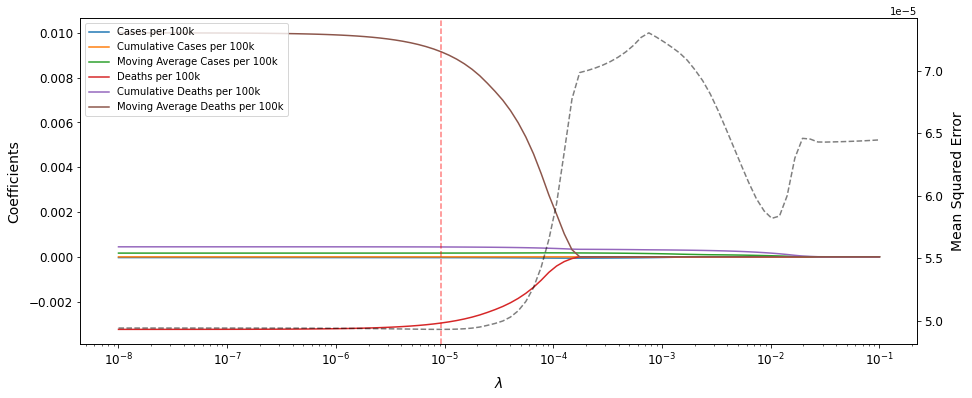

Cases per 100k
----------------------
F: 1.0122758535392733
p: 0.31495896222912023
Lasso: -3.880923600908752e-05

Cumulative Cases per 100k
----------------------
F: 51.24647239945023
p: 3.858261437260603e-12
Lasso: -6.2697315773968264e-06

Moving Average Cases per 100k
----------------------
F: 0.6359578246411893
p: 0.4256456223128253
Lasso: 0.00016450392041382006

Deaths per 100k
----------------------
F: 10.892930032878422
p: 0.0010508351840161404
Lasso: -0.0029593086290911523

Cumulative Deaths per 100k
----------------------
F: 22.161615787723573
p: 3.447190560068214e-06
Lasso: 0.0004372678717450571

Moving Average Deaths per 100k
----------------------
F: 3.467795717448327
p: 0.06329862309031595
Lasso: 0.009155339618958



In [8]:
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Long")
fulton_Fvals, fulton_pvals = f_regression(fulton_X, fulton_y)
fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(fulton_Fvals[i],fulton_pvals[i],fulton_coefs[i]))
    print()

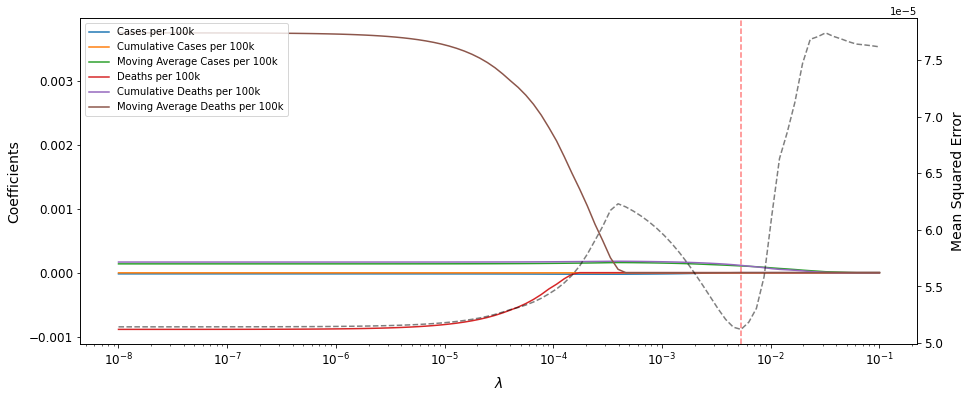

Cases per 100k
----------------------
F: 3.202086698242718
p: 0.07429145017054016
Lasso: 0.0

Cumulative Cases per 100k
----------------------
F: 67.35614382940301
p: 3.0531583593715074e-15
Lasso: -2.236870667497105e-06

Moving Average Cases per 100k
----------------------
F: 9.69848960681797
p: 0.001975260252314212
Lasso: 0.00010498361204586796

Deaths per 100k
----------------------
F: 1.457833894967748
p: 0.22797974325537287
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 34.50541151540782
p: 8.874352619733224e-09
Lasso: 0.00011363721738290502

Moving Average Deaths per 100k
----------------------
F: 22.625231240992655
p: 2.742451263105151e-06
Lasso: 0.0



In [9]:
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Long")
lowndes_Fvals, lowndes_pvals = f_regression(lowndes_X, lowndes_y)
lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(lowndes_Fvals[i],lowndes_pvals[i],lowndes_coefs[i]))
    print()

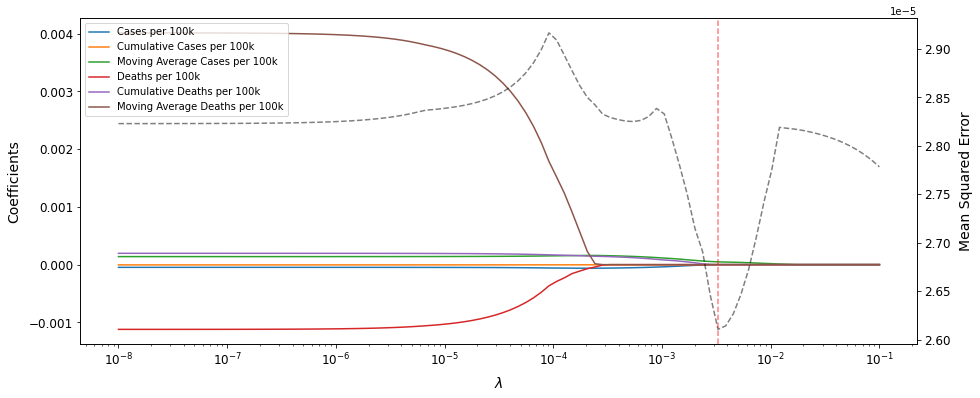

Cases per 100k
----------------------
F: 1.4485105480244895
p: 0.22947010418156535
Lasso: -4.251053667264886e-07

Cumulative Cases per 100k
----------------------
F: 16.393541074046563
p: 6.16694409117866e-05
Lasso: -4.2680603514149755e-07

Moving Average Cases per 100k
----------------------
F: 7.373440691700559
p: 0.0069026726843354255
Lasso: 4.79455059930291e-05

Deaths per 100k
----------------------
F: 1.567327842555143
p: 0.21131803459974052
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 16.607029897627374
p: 5.5346903062925554e-05
Lasso: 0.0

Moving Average Deaths per 100k
----------------------
F: 5.668714397001256
p: 0.017731630117217366
Lasso: 0.0



In [10]:
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Long")
chatham_Fvals, chatham_pvals = f_regression(chatham_X, chatham_y)
chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(chatham_Fvals[i],chatham_pvals[i],chatham_coefs[i]))
    print()

# Medium Trips

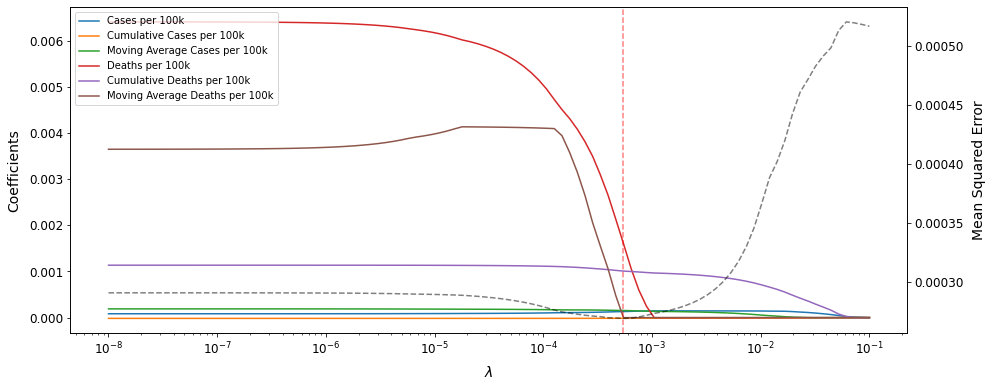

Cases per 100k
----------------------
F: 32.481020843057856
p: 2.320558029122256e-08

Cumulative Cases per 100k
----------------------
F: 14.272923196724275
p: 0.0001818485363862971

Moving Average Cases per 100k
----------------------
F: 27.075205220132467
p: 3.116014911289756e-07

Deaths per 100k
----------------------
F: 16.278335645187113
p: 6.537957828864367e-05

Cumulative Deaths per 100k
----------------------
F: 27.283260134151597
p: 2.817140614870978e-07

Moving Average Deaths per 100k
----------------------
F: 10.662995768617636
p: 0.0011859639766513919



In [22]:
state_trip_dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Medium")
state_Fvals, state_pvals = f_regression(state_X, state_y)
state_coefs = lasso_coefs(state_X, state_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}".format(state_Fvals[i],state_pvals[i]))
    print()

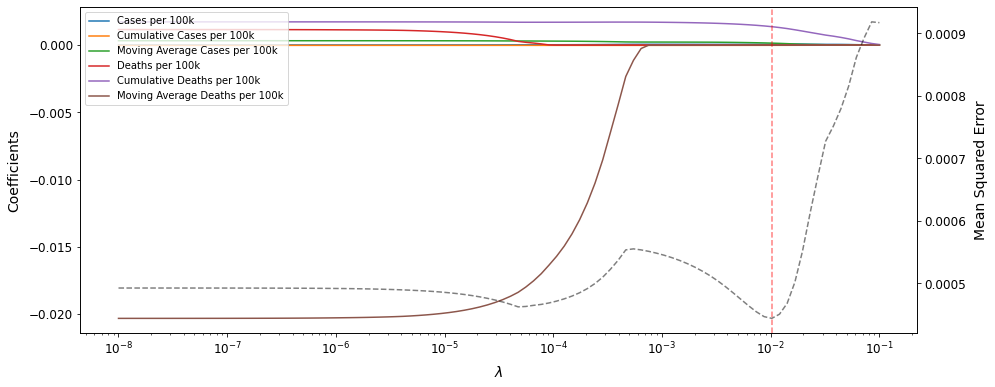

Cases per 100k
----------------------
F: 0.006597869422241581
p: 0.9353013377006022
Lasso: 6.519620717522175e-05

Cumulative Cases per 100k
----------------------
F: 53.182952707261414
p: 1.6108630255802815e-12
Lasso: -1.7411303271138406e-05

Moving Average Cases per 100k
----------------------
F: 1.1479642088432427
p: 0.28461377490098777
Lasso: 0.00014678372734327707

Deaths per 100k
----------------------
F: 22.976914540747835
p: 2.306294701926914e-06
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 14.839465926190455
p: 0.00013604473757936424
Lasso: 0.0013689957090457206

Moving Average Deaths per 100k
----------------------
F: 96.29515911126853
p: 1.5578198427259454e-20
Lasso: 0.0



In [12]:
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Medium")
fulton_Fvals, fulton_pvals = f_regression(fulton_X, fulton_y)
fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(fulton_Fvals[i],fulton_pvals[i],fulton_coefs[i]))
    print()

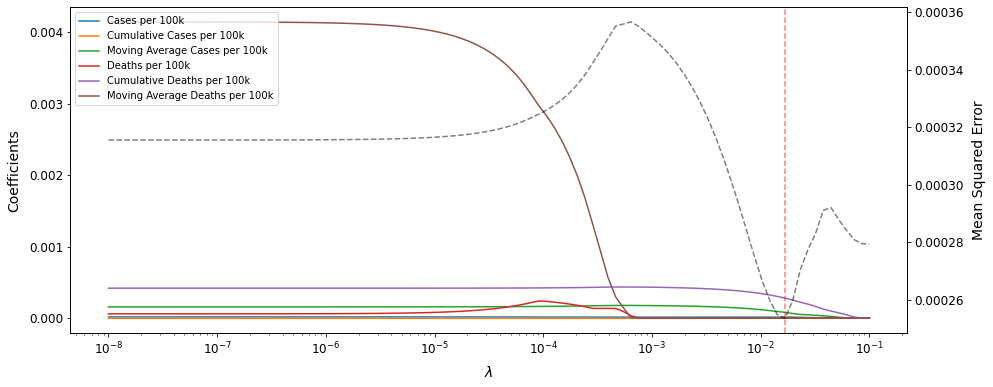

Cases per 100k
----------------------
F: 25.00683658094093
p: 8.525097691681704e-07
Lasso: 1.2665366317480238e-05

Cumulative Cases per 100k
----------------------
F: 33.48220653871147
p: 1.4414902841969597e-08
Lasso: -2.198317809307143e-06

Moving Average Cases per 100k
----------------------
F: 40.44536530430046
p: 5.464815907614237e-10
Lasso: 7.944782469003784e-05

Deaths per 100k
----------------------
F: 6.601700680618585
p: 0.010545138776108718
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 62.467539419852585
p: 2.5900088542324788e-14
Lasso: 0.0002795293220693344

Moving Average Deaths per 100k
----------------------
F: 26.108332004188203
p: 4.983376053877093e-07
Lasso: 0.0



In [13]:
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Medium")
lowndes_Fvals, lowndes_pvals = f_regression(lowndes_X, lowndes_y)
lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(lowndes_Fvals[i],lowndes_pvals[i],lowndes_coefs[i]))
    print()

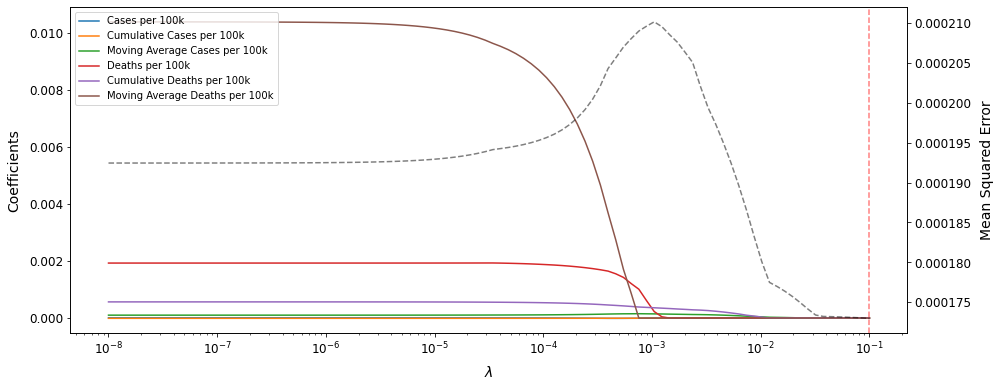

Cases per 100k
----------------------
F: 36.56212552424252
p: 3.362127416616931e-09
Lasso: 0.0

Cumulative Cases per 100k
----------------------
F: 138.01557833734955
p: 1.2660860111099352e-27
Lasso: 2.492354968461926e-06

Moving Average Cases per 100k
----------------------
F: 52.9752044030736
p: 1.7687460939073258e-12
Lasso: 0.0

Deaths per 100k
----------------------
F: 44.28811622631569
p: 9.228731500723711e-11
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 140.2038767268306
p: 5.575347462934485e-28
Lasso: 0.0

Moving Average Deaths per 100k
----------------------
F: 120.23188652072169
p: 1.1301461067510694e-24
Lasso: 0.0



In [14]:
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Medium")
chatham_Fvals, chatham_pvals = f_regression(chatham_X, chatham_y)
chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(chatham_Fvals[i],chatham_pvals[i],chatham_coefs[i]))
    print()

# Short Trips

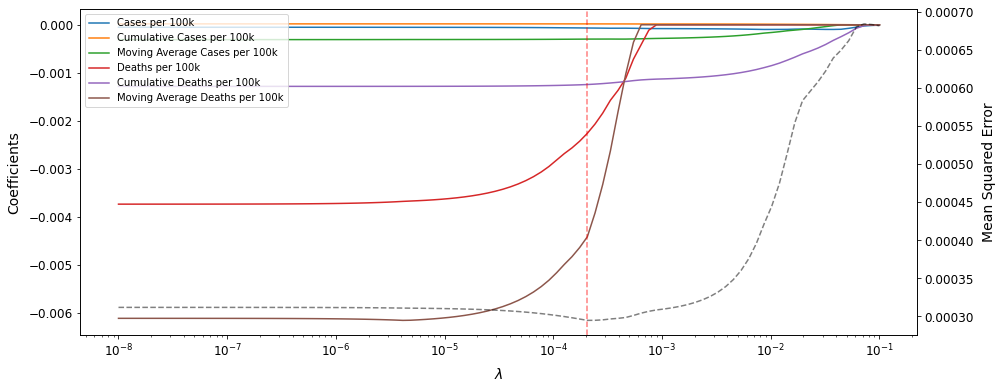

Cases per 100k
----------------------
F: 25.365520288834592
p: 7.155952503694983e-07

Cumulative Cases per 100k
----------------------
F: 3.3179611949555907
p: 0.0692643004059921

Moving Average Cases per 100k
----------------------
F: 22.209200228489973
p: 3.3671477963299283e-06

Deaths per 100k
----------------------
F: 6.077900684814137
p: 0.014102139625096197

Cumulative Deaths per 100k
----------------------
F: 10.77327718625205
p: 0.0011190791952857173

Moving Average Deaths per 100k
----------------------
F: 4.55836128506786
p: 0.033357974077842974



In [23]:
state_trip_dates, state_y, state_X, feature_labels = covid_feature_extraction.state_extraction("Short")
state_Fvals, state_pvals = f_regression(state_X, state_y)
state_coefs = lasso_coefs(state_X, state_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}".format(state_Fvals[i],state_pvals[i]))
    print()

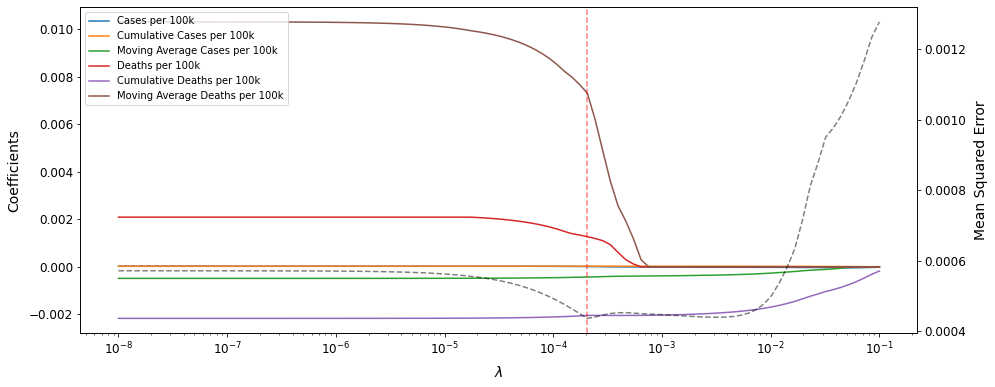

Cases per 100k
----------------------
F: 0.12011504219248749
p: 0.7290897436122625
Lasso: 1.108297499008004e-05

Cumulative Cases per 100k
----------------------
F: 65.45629950792085
p: 6.987875289421038e-15
Lasso: 2.6018994012701726e-05

Moving Average Cases per 100k
----------------------
F: 1.214045079050032
p: 0.2711868453260562
Lasso: -0.00042809220615446013

Deaths per 100k
----------------------
F: 23.73181889451524
p: 1.5914391182841215e-06
Lasso: 0.0012692579079684348

Cumulative Deaths per 100k
----------------------
F: 20.161393661040652
p: 9.293309512075184e-06
Lasso: -0.002046271540827585

Moving Average Deaths per 100k
----------------------
F: 70.6667463840271
p: 7.276129900627875e-16
Lasso: 0.007305025342955218



In [16]:
dates, fulton_y, fulton_X, feature_labels = covid_feature_extraction.county_extraction("Fulton","Short")
fulton_Fvals, fulton_pvals = f_regression(fulton_X, fulton_y)
fulton_coefs = lasso_coefs(fulton_X, fulton_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(fulton_Fvals[i],fulton_pvals[i],fulton_coefs[i]))
    print()

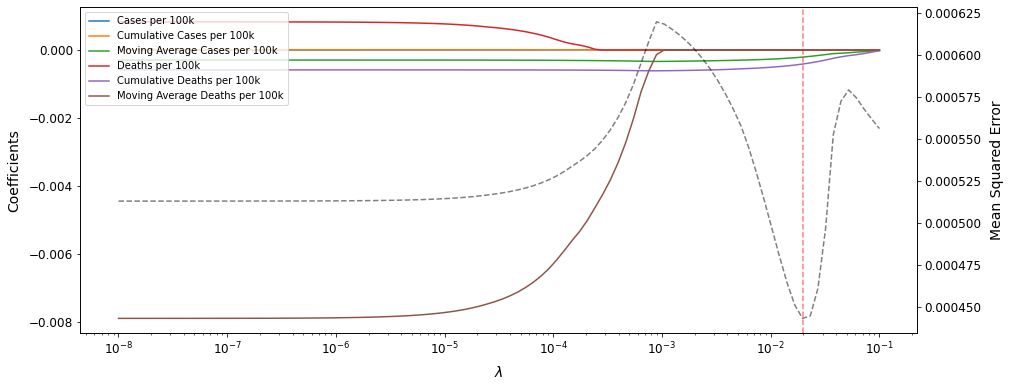

Cases per 100k
----------------------
F: 22.675864733746835
p: 2.6748666085005664e-06
Lasso: -1.05703658206751e-06

Cumulative Cases per 100k
----------------------
F: 2.4504731949730263
p: 0.11827043304029183
Lasso: 4.727077452436536e-06

Moving Average Cases per 100k
----------------------
F: 41.285310928656514
p: 3.6986322053512147e-10
Lasso: -0.00020748179932856054

Deaths per 100k
----------------------
F: 6.546988895799733
p: 0.010868867029343261
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 14.820039966909174
p: 0.00013740294701989993
Lasso: -0.0004122414406177643

Moving Average Deaths per 100k
----------------------
F: 36.98607886612482
p: 2.7544967079776315e-09
Lasso: 0.0



In [17]:
dates, lowndes_y, lowndes_X, feature_labels = covid_feature_extraction.county_extraction("Lowndes","Short")
lowndes_Fvals, lowndes_pvals = f_regression(lowndes_X, lowndes_y)
lowndes_coefs = lasso_coefs(lowndes_X, lowndes_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(lowndes_Fvals[i],lowndes_pvals[i],lowndes_coefs[i]))
    print()

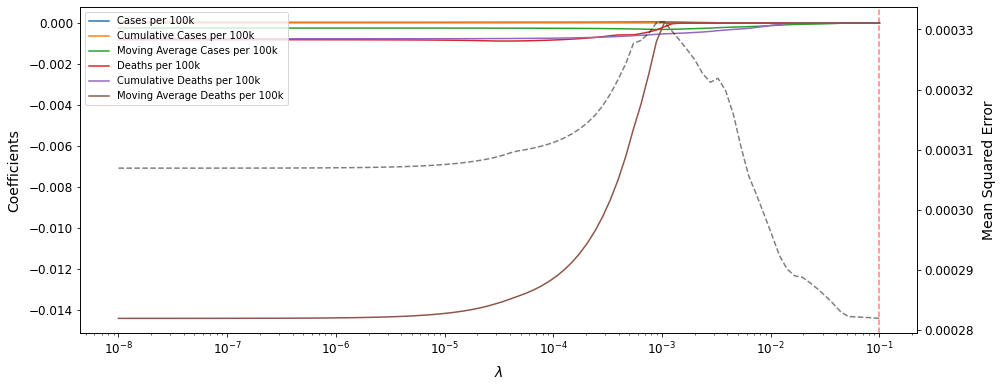

Cases per 100k
----------------------
F: 33.73170792834874
p: 1.2805002486040128e-08
Lasso: 0.0

Cumulative Cases per 100k
----------------------
F: 76.74833087387816
p: 5.3691812922589734e-17
Lasso: -2.2391638630793983e-06

Moving Average Cases per 100k
----------------------
F: 55.02936446185942
p: 7.032008600698955e-13
Lasso: 0.0

Deaths per 100k
----------------------
F: 30.840705393112398
p: 5.078982289414319e-08
Lasso: 0.0

Cumulative Deaths per 100k
----------------------
F: 77.81646638311962
p: 3.4094546299106916e-17
Lasso: 0.0

Moving Average Deaths per 100k
----------------------
F: 112.51035271989038
p: 2.325861358315734e-23
Lasso: 0.0



In [18]:
dates, chatham_y, chatham_X, feature_labels = covid_feature_extraction.county_extraction("Chatham","Short")
chatham_Fvals, chatham_pvals = f_regression(chatham_X, chatham_y)
chatham_coefs = lasso_coefs(chatham_X, chatham_y, feature_labels, plot=True)
for i in range(len(feature_labels)):
    print(feature_labels[i])
    print("----------------------")
    print("F: {}\np: {}\nLasso: {}".format(chatham_Fvals[i],chatham_pvals[i],chatham_coefs[i]))
    print()